In [434]:
from mitiq import zne, benchmarks, MeasurementResult, rem
from qiskit import *
import networkx as nx
from qiskit_aer import *
import matplotlib.pyplot as plt
from mitiq.rem import generate_inverse_confusion_matrix, execute_with_rem
from mitiq.rem.inverse_confusion_matrix import mitigate_measurements

from collections import defaultdict
from qiskit.circuit import Gate
import numpy as np
import tomlkit
import toml
import functools
import qiskit_aer.noise as noise
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_aer.noise import (NoiseModel, thermal_relaxation_error)
from mitiq.zne.inference import Factory, RichardsonFactory


In [435]:
class appBackend():
##########################################################################
#
#
#                        Execute related things
#
#
##########################################################################
    def execute(self, circuit, backend=AerSimulator(), shots=100, expected_bitstring='default_bs', path_to_metadata='default_path', tech = None, noise_model = None, p_flip = 0.25):
        qc = circuit.copy()
        depth = qc.depth()
        ops_dict = qc.count_ops()
        qc.measure_all()

        gate_counts = {1: 0, 2: 0}
        for inst in circuit.data:
            if isinstance(inst.operation, Gate):
                qubit_count = len(inst.qubits)
                gate_counts[qubit_count] = gate_counts.get(qubit_count, 0) + 1

        transpiled_qc = transpile(qc, backend=backend, optimization_level=0)
        transpiled_depth = transpiled_qc.depth()

        if noise_model is not None:
            result = backend.run(transpiled_qc, noise_model=noise_model, shots=shots, optimization_level=0).result()
        else:
            result = backend.run(transpiled_qc, shots=shots, optimization_level=0).result()
        # print(result)
        msmt_counts = result.get_counts(qc)
        inverse_bs = expected_bitstring[::-1]
        final_bitstring = ''.join(str(x) for x in inverse_bs)
        if msmt_counts.get(final_bitstring) is None:
            expectation_value = 0.
        else:
            expectation_value = msmt_counts.get(final_bitstring) / 100


        ###>------------------- Metadata part --------------------<###
        self.makeMetadata(path_to_metadata, gate_counts, depth, transpiled_depth, msmt_counts, expectation_value, ops_dict)

        if tech == "REM":
             return MeasurementResult(msmt_counts)


        return expectation_value
    
    def makeNoisy(self, noise_model = None):
        # Load a basic noise model if none given
        if noise_model == None:
            # Error probabilities
            prob_1 = 0.001  # 1-qubit gate
            prob_2 = 0.01   # 2-qubit gate

            # Depolarizing quantum errors
            error_1 = noise.depolarizing_error(prob_1, 1)
            error_2 = noise.depolarizing_error(prob_2, 2)

            # Readout errors (For REM implimentation)
            readout_error_0 = noise.ReadoutError([[0.9, 0.1], [0.2, 0.8]])  # Example error for qubit 0
            readout_error_1 = noise.ReadoutError([[0.85, 0.15], [0.1, 0.9]])  # Example error for qubit 1

            # Add errors to noise model
            noise_model = noise.NoiseModel()
            noise_model.add_readout_error(readout_error_0, [0])
            noise_model.add_readout_error(readout_error_1, [1])
            noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
            noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        return noise_model


    def batch_execute(self, circ_list, bs_list, technique_name, noisy=False, noise_model = None, backend=AerSimulator(), path_to_metadata='metadata.toml',shots=100, p_flip = .25):
        exp_val_list = []
        expectation_value = 0

        for i,circ in enumerate(circ_list):
            self.initMetadata(path_to_metadata,i=i, technique_name=technique_name)
            if noisy:
                print("Noisy...")
                noise_model = self.makeNoisy(noise_model)
                new_executor = functools.partial(
                        self.execute,noise_model=noise_model,
                            backend=backend, shots=shots,
                            expected_bitstring=bs_list[i],
                            path_to_metadata=path_to_metadata, tech = technique_name)
                
                # Non_mitigated_expec = self.execute(circ, backend=backend, shots=shots, expected_bitstring=bs_list[i], path_to_metadata=path_to_metadata, noise_model = noise_model)
                if technique_name == 'REM':
                    print("Running the REM")
                    # MITIQ's REM error mitigation
                    self.addToMetadata(path_to_metadata, item = {"p_flip": p_flip})

                    # expectation_value = self.execute(circ, backend=backend, shots=shots,
                    #                                 expected_bitstring=bs_list[i], path_to_metadata=path_to_metadata,
                    #                                 tech = technique_name, noise_model = noise_model, p_flip = p_flip)
                    inverse_confusion_matrix = generate_inverse_confusion_matrix(len(bs_list[i]), p_flip, p_flip)
                    new_executor = functools.partial(
                                                    self.execute, backend=backend, shots=shots,
                                                    expected_bitstring=bs_list[i], path_to_metadata=path_to_metadata,
                                                    tech = technique_name, noise_model = noise_model, p_flip = p_flip)
                    expectation_value=rem.execute_with_rem(
                                            circ,
                                            new_executor,
                                            observable=None,
                                            inverse_confusion_matrix=inverse_confusion_matrix,
                                            )
                    msmt_counts = expectation_value.get_counts()
                    inverse_bs = bs_list[i][::-1]
                    final_bitstring = ''.join(str(x) for x in inverse_bs)
                    if msmt_counts.get(final_bitstring) is None:
                        expectation_value = 0.
                    else:
                        expectation_value = msmt_counts.get(final_bitstring) / 100
                    print(expectation_value)
                    self.addToMetadata(path_to_metadata, item = {f"Overall_expectation_value": expectation_value})

                    
                elif technique_name == 'ZNE':
                    # MITIQ's Zero-Noise Extrapolation
                    new_executor = functools.partial(
                        self.execute, noise_model=noise_model,
                        backend=backend, shots=shots,
                        expected_bitstring=bs_list[i],
                        path_to_metadata=path_to_metadata)  
                    expectation_value = zne.execute_with_zne(circ, executor=new_executor)
                                
            else:
                if technique_name == 'ZNE':
                    # MITIQ's Zero-Noise Extrapolation
                    new_executor = functools.partial(
                        self.execute, backend=backend,
                        shots=shots, expected_bitstring=bs_list[i],
                        path_to_metadata=path_to_metadata)
                    expectation_value = zne.execute_with_zne(circ, executor=new_executor)

            self.addToMetadata(path_to_metadata, item = {"Overall_expectation_value": expectation_value})
            exp_val_list.append(expectation_value)
        return exp_val_list
    

##########################################################################
#
#
#                        Metadata related things
#
#
##########################################################################
    def initMetadata(self, path_to_metadata, technique_name, i=0, new_flag= False, multi = False):
        if new_flag: # On first iteration
            # Create toml file type
            metadata = tomlkit.document()
            
            #Add an array that has zne in it called techniques
            metadata.add('techniques',[])
            #Write toml file as metadata.toml
            with open(path_to_metadata, 'w') as f:
                    toml.dump(metadata, f)
            return
            # metadata['techniques'].append("cir_" + str(i) + "_"+ technique_name) 
            # #Get the last technique in the techniques array
            # tech = str(metadata['techniques'][-1])
        else:
            with open(path_to_metadata, 'r') as f:
                    metadata = toml.load(f)
            #Add an array that has the lastest technique in it called techniques
            if not multi:
                metadata['techniques'].append(["cir_" + str(i) + "_" + technique_name]) 
                #Get the last technique in the techniques array
                tech = str(metadata['techniques'][-1])
                tech = str(tech).translate({ord(i): None for i in '[]\', '})
            else:
                #Get the last technique in the techniques array
                tech = "cir_" + str(i) + "_" + technique_name
                tech = str(tech).translate({ord(i): None for i in '[]\', '})
                 

        #Make a dictionary for cir_i_technique_name_
        metadata[tech]= tomlkit.table()

        # Add number of time run and make dictionary
        metadata[tech]["numRuns"] = 0
        metadata[tech][str(metadata[tech]["numRuns"])]= tomlkit.table()

        #Write toml file as metadata.toml
        with open(path_to_metadata, 'w') as f:
                toml.dump(metadata, f)
        return
    
    def makeMetadata(self, path_to_metadata, gate_counts, depth, transpiled_depth, msmt_counts, expectation_value, ops_dict):   
        with open(path_to_metadata, 'r') as f:
            metadata = toml.load(f) 
        # get lastest Technique (error mitigation implementation)
        tech = metadata['techniques'][-1]
        tech = str(tech).translate({ord(i): None for i in '[]\', '})

        # get current run count --> number of runs for current technique
        run_count = str(metadata[tech]["numRuns"])

        # # dictonary for the current circuit
        metadata[tech][run_count] = tomlkit.table()

        # dictonary for counts of 1 and 2 qubit gates
        metadata[tech][run_count]["1 and 2 qubit operator counts"] = tomlkit.table()

        # add current counts of 1 and 2 qubit gates
        for k, v in gate_counts.items():
            metadata[tech][run_count]["1 and 2 qubit operator counts"][str(k)  + " qubit gate operator(s)"] = int(v) 

        # add current circuit depth
        metadata[tech][run_count]['circuit depth'] = int(depth)

        # dictonary for the individual operator counts
        metadata[tech][run_count]['Individual operator counts'] = tomlkit.table()

        # add current individual operator counts
        for k, v in ops_dict.items():
            metadata[tech][run_count]['Individual operator counts'][str(k) + " gates"] = int(v) 

        # add current transpiled circuit depth
        metadata[tech][run_count]['Transpiled circuit depth'] = int(transpiled_depth)

        # dictonary for the Measurement Results
        metadata[tech][run_count]["Measurement Results"] = tomlkit.table()

        # add all current Measurement Results
        for k, v in msmt_counts.items():
            metadata[tech][run_count]["Measurement Results"][k.replace(" ","")] = int(v)+1-1 

        # add calculated expectation value --> frequency of correct_bitstring msmt
        metadata[tech][run_count]['expectation_value'] = float(expectation_value)

        # update run count for next circuit 
        metadata[tech]["numRuns"] = int(metadata[tech]["numRuns"]) + 1  

        with open(path_to_metadata, 'w') as f:
            toml.dump(metadata, f)
        return

    def addToMetadata(self, path_to_metadata, item = {"Nothing": None}):

        with open(path_to_metadata, 'r') as f:
            metadata = toml.load(f) 

        for key in item.keys():
            # get lastest Technique (error mitigation implementation)
            tech = metadata['techniques'][-1]
            tech = str(tech).translate({ord(i): None for i in '[]\', '})
            # get current run count --> number of runs for current technique
            metadata[tech][key] = item[key]
        
        with open(path_to_metadata, 'w') as f:
            toml.dump(metadata, f)
        return

    
    def summed(self, path_to_metadata, sums, agr):
        # Create toml file type
        sums = {agr:sums}
        metadata = tomlkit.loads(tomlkit.dumps(sums))
        with open(path_to_metadata, 'a') as f:
            toml.dump(metadata, f)
        return
         


##########################################################################
#
#
#                        Ploting related things
#
#
##########################################################################
    def scale_for_plot(self, c_list, path_to_metadata, tech = "ZNE"):
        add_params = {}

        og_params = self.get_original_circ_counts(c_list)
        sums = self.sumForPlot(path_to_metadata=path_to_metadata, tech=tech)
        add_params["depth"] = [x - y for x,y in zip(sums["circuit depth"], og_params["depth"])]
        add_params["1 qubit gates"] = [x-y for x,y in zip(sums["1 qubit gates"], og_params["1 qubit gates"])]
        add_params["2 qubit gates"] = [x-y for x,y in zip(sums["2 qubit gates"],og_params["2 qubit gates"])]

        return add_params
    
    def sumForPlot(self, path_to_metadata,tech ="ZNE"):
            sums = {} 
            with open(path_to_metadata, 'r') as f:
                    metadata = toml.load(f)
            numOfCirc = len(metadata['techniques'])
            
            
            sums["circuit depth"] = [0 for x in range(numOfCirc)]
            sums["Transpiled circuit depth"] = [0 for x in range(numOfCirc)]
            sums["1 qubit gates"] = [0 for x in range(numOfCirc)]
            sums["2 qubit gates"] = [0 for x in range(numOfCirc)]
            sums[f"{tech}_Overall_expectation_value"] = [0 for x in range(numOfCirc)]
            
            for k in range(numOfCirc):
                    print("Doing cir_" + str(k) + "_"+ tech + " summing.........")
                    currentCirc = metadata["cir_" + str(k) + "_"+ tech]
                    for i in range(currentCirc["numRuns"]):
                            sums["circuit depth"][k] += int(currentCirc[str(i)]["circuit depth"])
                            sums["Transpiled circuit depth"][k] += int(currentCirc[str(i)]["Transpiled circuit depth"])
                            sums["1 qubit gates"][k] += int(currentCirc[str(i)]["1 and 2 qubit operator counts"]["1 qubit gate operator(s)"])  
                            sums["2 qubit gates"][k] += int(currentCirc[str(i)]["1 and 2 qubit operator counts"]["2 qubit gate operator(s)"])
                    sums[f"{tech}_Overall_expectation_value"][k] = metadata[f"cir_{k}_{tech}"]["Overall_expectation_value"]
            return sums

    def plot_it(self, tech, plotSize, path_to_metadata,noisy=False, p_flip =.25, noise_model = None):      
        if tech == "Zero-Noise Extrapolation":
            tech = 'ZNE'
        elif tech == "Readout error Mitigation":
            tech = "REM"
        else:
             tech = "None"
        print(f"tech = {tech}")

        fig, ax = plt.subplots(figsize=plotSize)
        circs, bss, arr = self.get_circ_bs_lists(max_qbits=4)

        self.initMetadata(path_to_metadata, tech, new_flag=True)
        Exp = self.batch_execute(circ_list=circs, bs_list=bss, technique_name=tech, path_to_metadata=path_to_metadata, noisy=noisy, p_flip=p_flip,noise_model=noise_model)
        add_params = self.scale_for_plot(circs, path_to_metadata=path_to_metadata, tech=tech)
        ax.set_xlabel(r'$N_{qubits}$')
        ax.set_ylabel('Accuracy')

        c = ax.plot(arr, Exp, '.-', color="red", label='ex')
        # c = ax.plot(arr, add_params["depth"], '.-', color="mediumseagreen", label='Additional Depth')
        # n = ax.plot(arr, add_params["1 qubit gates"], '.-', color="dodgerblue", label='# Added Single Qubit Gates')
        # t  = ax.plot(arr, add_params["2 qubit gates"], '.-', color="blue", label='# Added Two Qubit Gates')
        return fig,ax
    
##########################################################################
#
#
#                           Random things
#
#
##########################################################################

    def get_circuit_and_bs(self, layer_depth, n_qubits, seed=None):
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
            nlayers=layer_depth,
            two_qubit_gate_prob=1.0,
            connectivity_graph=nx.complete_graph(n_qubits),
            two_qubit_gate_name="CNOT",
            seed=seed,
            return_type="qiskit",
        )        
        return circuit, correct_bitstring
    

    def get_circ_bs_lists(self, max_qbits):
        qbit_count_arr = np.arange(1,max_qbits+1,1)
        c_list = []
        b_list = []

        for k in qbit_count_arr:
            c, b = self.get_circuit_and_bs(20,k)
            c_list.append(c)
            b_list.append(b)

        return c_list, b_list, qbit_count_arr
    

    def get_original_circ_counts(self, c_list):
        og_params = {}

        og_params["depth"] = [0 for x in range(len(c_list))]
        og_params["1 qubit gates"] = [0 for x in range(len(c_list))]
        og_params["2 qubit gates"] = [0 for x in range(len(c_list))]

        for k in range(len(c_list)):
            og_params["depth"][k] = c_list[k].depth()
            counts = defaultdict(int)

            for inst in c_list[k].data:
                if isinstance(inst.operation, Gate):
                    counts[len(inst.qubits)] += 1
                
                o = {k: v for k, v in counts.items()}
                        
                single_qubit_gates = (o.get(1)) if o.get(1) is not None else 0
                two_qubit_gates = (o.get(2)) if o.get(2) is not None else 0
                
                og_params["1 qubit gates"][k] = single_qubit_gates
                og_params["2 qubit gates"][k] = two_qubit_gates 

        return og_params

    def thermal_relaxation_noise_ionq(self, N, r_err = 0.005):       # Default readout error set to 0.5%, can change , N = num_qubits in circ                    
        
            # T1 and T2 values for qubits 0-N
            T1s = np.random.normal(1.1e10, 0.2e10, N)  # Sampled N values from normal dist, w/ mean = 1.1e10, std = 2e9 us, (converted to ns)
            T2s = np.random.normal(2e8, 0.2e8, N)      # Sampled N values from normal dist, w/ mean = 2e5, std = 2e4 us (converted to ns)

            # Instruction times (in nanoseconds)
            time_1 = 10000
            time_2 = 210000   

            noise_thermal = NoiseModel()               # Initialize noise model w ansatz gates
            noise_thermal.add_basis_gates(['rx', 'rz', 'cx'])

            # QuantumError objects
            errors_rx  = [thermal_relaxation_error(t1, t2, time_1)            # Make tuples of errors for rx, rz gates 
                        for t1, t2 in zip(T1s, T2s)]
            errors_rz  = [thermal_relaxation_error(t1, t2, time_1)
                        for t1, t2 in zip(T1s, T2s)]
            errors_sx  = [thermal_relaxation_error(t1, t2, time_1)
                        for t1, t2 in zip(T1s, T2s)]
            errors_id  = [thermal_relaxation_error(t1, t2, time_1)
                        for t1, t2 in zip(T1s, T2s)]
            errors_cx  = [thermal_relaxation_error(t1, t2, time_2).expand(thermal_relaxation_error(t1, t2, time_2))
                        for t1, t2 in zip(T1s, T2s) for t1, t2 in zip(T1s, T2s)]
            
            # Readout error:
            probs = ReadoutError([[1 - r_err, r_err], [r_err, 1 - r_err]])
            
            # Apply error to all qubits in circuit from randomly sampled parameters
            for j in range(N):
                noise_thermal.add_quantum_error(errors_rx[j], "rx", [j])
                noise_thermal.add_quantum_error(errors_rz[j], "rz", [j])
                noise_thermal.add_quantum_error(errors_sx[j], "sx", [j])
                noise_thermal.add_quantum_error(errors_id[j], "id", [j])
                noise_thermal.add_readout_error(probs, [j])
                for k in range(N):
                    noise_thermal.add_quantum_error(errors_cx[k], "cx", [j, k])

            sim_noise = AerSimulator(noise_model=noise_thermal)
            return noise_thermal

In [431]:
# circs, bss, arr = appBackend().get_circ_bs_lists(max_qbits=4)
# appBackend.batch_execute(circ_list=circs, bs_list=bss, executor=appBackend.execute)
sums = appBackend().sumForPlot(path_to_metadata="metadata.toml",tech ="REM")

Doing cir_0_REM summing.........


KeyError: 'cir_0_REM'

tech = REM
Noisy...
Running the REM
0.01
Noisy...
Running the REM
0.01
Noisy...
Running the REM
0.0
Noisy...
Running the REM
0.0
Doing cir_0_REM summing.........
Doing cir_1_REM summing.........
Doing cir_2_REM summing.........
Doing cir_3_REM summing.........
Doing cir_0_REM summing.........
Doing cir_1_REM summing.........
Doing cir_2_REM summing.........
Doing cir_3_REM summing.........
None
tech = REM
Noisy...
Running the REM
0.0
Noisy...
Running the REM
0.0
Noisy...
Running the REM
0.0
Noisy...
Running the REM
0.0
Doing cir_0_REM summing.........
Doing cir_1_REM summing.........
Doing cir_2_REM summing.........
Doing cir_3_REM summing.........
Doing cir_0_REM summing.........
Doing cir_1_REM summing.........
Doing cir_2_REM summing.........
Doing cir_3_REM summing.........
None
tech = REM
Noisy...
Running the REM
0.01
Noisy...
Running the REM
0.02
Noisy...
Running the REM
0.0
Noisy...
Running the REM
0.01
Doing cir_0_REM summing.........
Doing cir_1_REM summing.........
Doing cir_

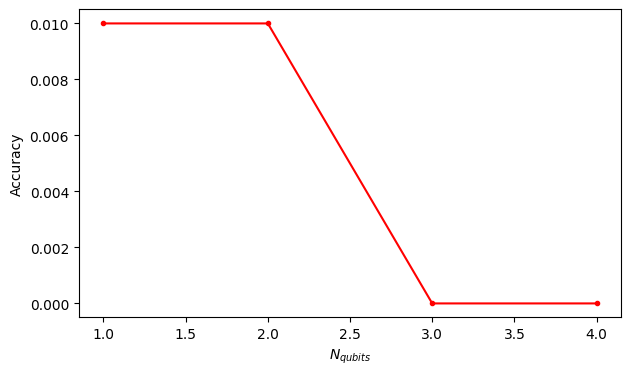

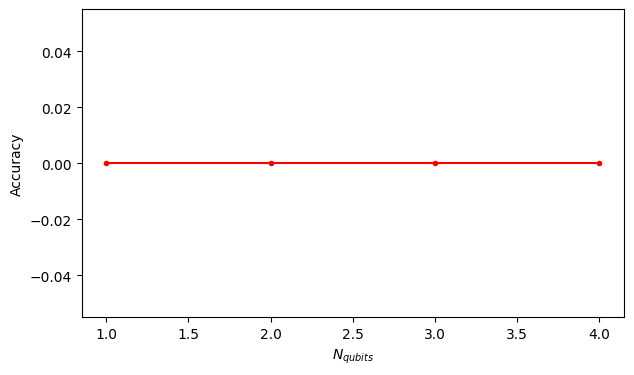

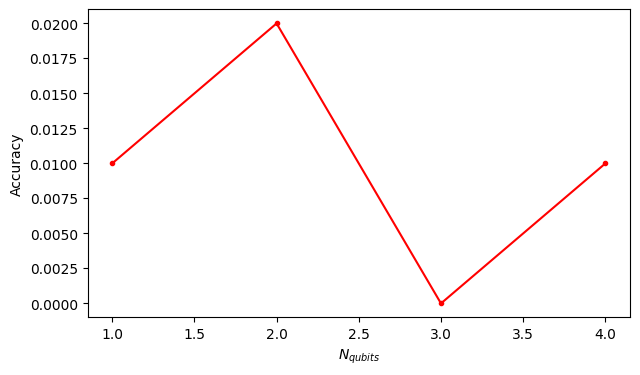

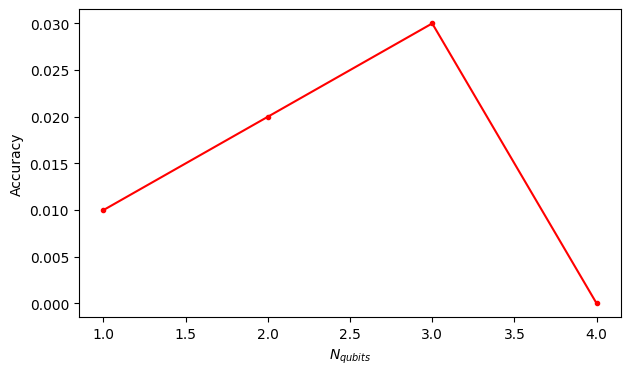

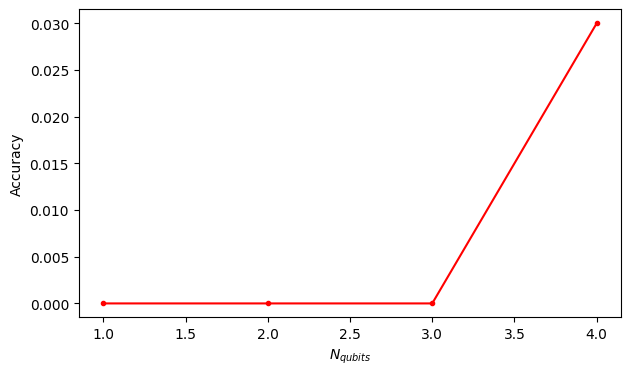

In [436]:
# This is to run parameters for the batch
p_flips = [0.05,.10,.20,.40,.80] # this is the parameter for REM
tech ="REM"
#Clears old summary file of the tech
metadata = tomlkit.document()
with open(f"summary_{tech}.toml", 'w') as f:
        toml.dump(metadata, f)

for p_flip in p_flips:
    appBackend().plot_it(tech="Readout error Mitigation", plotSize = (7,4), path_to_metadata = f"metadata_{tech}_{p_flip}.toml", noisy=True,p_flip=p_flip, noise_model=appBackend().thermal_relaxation_noise_ionq(4))
    sums = appBackend().sumForPlot(path_to_metadata=f"metadata_{tech}_{p_flip}.toml",tech =tech)
    print(appBackend().summed(path_to_metadata= f"summary_{tech}.toml",sums=sums, agr=f"p_flip_{p_flip}"))



tech = ZNE
Noisy...
Noisy...
Noisy...
Noisy...
Doing cir_0_ZNE summing.........
Doing cir_1_ZNE summing.........
Doing cir_2_ZNE summing.........
Doing cir_3_ZNE summing.........


(<Figure size 700x400 with 1 Axes>,
 <Axes: xlabel='$N_{qubits}$', ylabel='Accuracy'>)

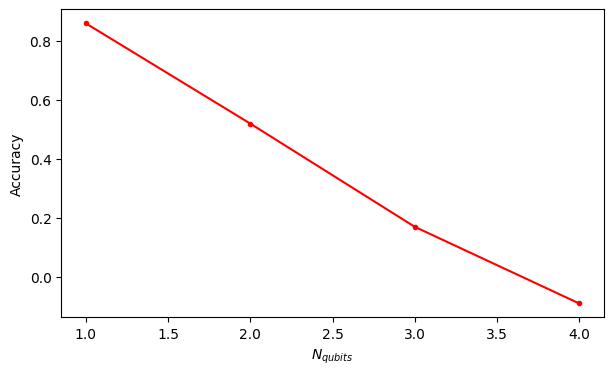

In [399]:
appBackend().plot_it(tech="Zero-Noise Extrapolation", plotSize = (7,4), path_to_metadata = "metadata.toml", noisy=True)